In [1]:
# Import the libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xgboost
import statistics
import seaborn as sns
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import explained_variance_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import learning_curve
from prettytable import PrettyTable

### Indroduction
#####  The Zomato data set consists of information regarding all the restaurant outlets of Bengaluru city (India). The interesting fact about the dataset is it has information about 12,000 different restaurants and various types of food offered. Zomato has their website and the URL field in the data set consist of restaurant URL in Zomato website. Data set has information about various restaurant types which are bifurcated on the basis of the food offered like Indian, Chinese, Thai, South Indian etc. Data set has information about the rating of that particular restaurant outlet by the votes which defines the likeliness of that outlet i.e. how prominent that outlet is amongst the people of Bengaluru. Due to busyness of life, people have tendency to order the food online and that’s where Zomato comes handy which provides the medium to order the food online. Zomato decides delivery rate based on the distance, so it is decided by the location of that restaurant. The rate out of 5 is provided on basis of number of votes. Also, the insights of that data give the approximate cost of dining for two people, and nowadays almost all the outlets provide the way to book a table online. People visiting the restaurants are asked for the feedback by that restaurant, review list contains the information about the rating and the list of reviews from multiple customers, some of them are excellent and some of them are average and some are bad. There are some restaurants which are famous for their particular dish and the information under the dishes liked gives the insight regarding the same.

#https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants

### Read file and Load data

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Read the file and load the data (2.a, 2.b)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
def readFile(fileName):
    fileData = pd.read_csv(fileName)
    print('ATTRIBUTES INFO')
    fileData.info()
    return fileData

data = readFile('zomato.csv')

ATTRIBUTES INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list   

In [4]:
# Let's print the data
def printData(data):
    print(data.head())

printData(data)

                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5  

### Explore data

In [5]:
# Let's check how many null values are there in each attributes
# https://www.kaggle.com/sriramvsharma/finding-the-best-restaurants-in-bangalore-2d4897
def countNullPercentage(data):
    print(((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2))
    
countNullPercentage(data)

url                             0.00
address                         0.00
name                            0.00
online_order                    0.00
book_table                      0.00
rate                           15.03
votes                           0.00
phone                           2.34
location                        0.04
rest_type                       0.44
dish_liked                     54.29
cuisines                        0.09
approx_cost(for two people)     0.67
reviews_list                    0.00
menu_item                       0.00
listed_in(type)                 0.00
listed_in(city)                 0.00
dtype: float64


Restaurents delivering online order or not


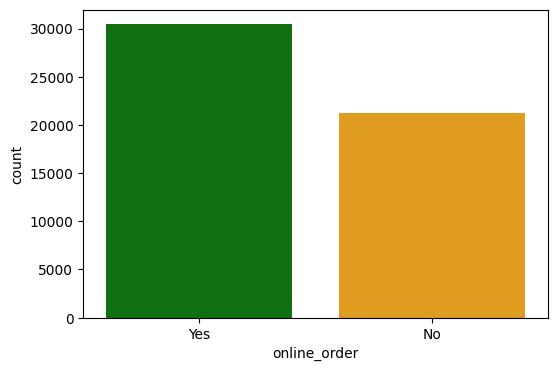

In [8]:
# https://www.kaggle.com/poojanagure/zomato-biginner-analysis
# Observation: In Bengaluru, Around 60% restaurants offer online order facility.
print('Restaurents delivering online order or not')
sns.countplot(x=data['online_order'] ,palette=['green', 'orange'])
fig=plt.gcf()
fig.set_size_inches(6,4)

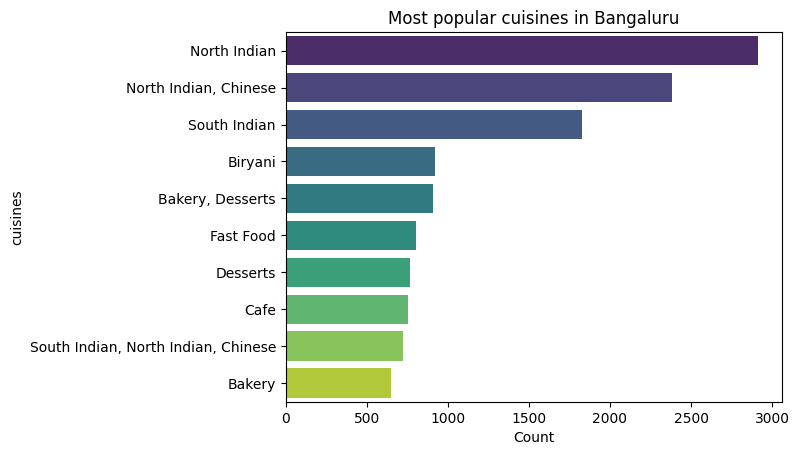

In [9]:
# https://www.kaggle.com/poojanagure/zomato-biginner-analysis
# Observation: North Indian is the most popular cuisine. Second most is north Indian 
# and Chinese.
plt.title('Most popular cuisines in Bangaluru')
cuisines=data['cuisines'].value_counts()[:10]
x = cuisines
y = cuisines.index
sns.barplot(x = x , y = y, palette="viridis")
plt.xlabel('Count')
fig.set_size_inches(15,10)

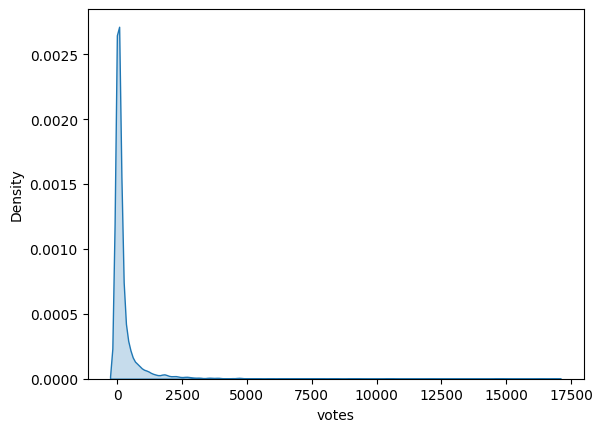

In [10]:
# https://seaborn.pydata.org/generated/seaborn.distplot.html
# Observation: For most of the restaurants, vote count in between 0 to 2500.
_ = sns.distplot(data['votes'], hist=False, kde_kws={"shade": True})

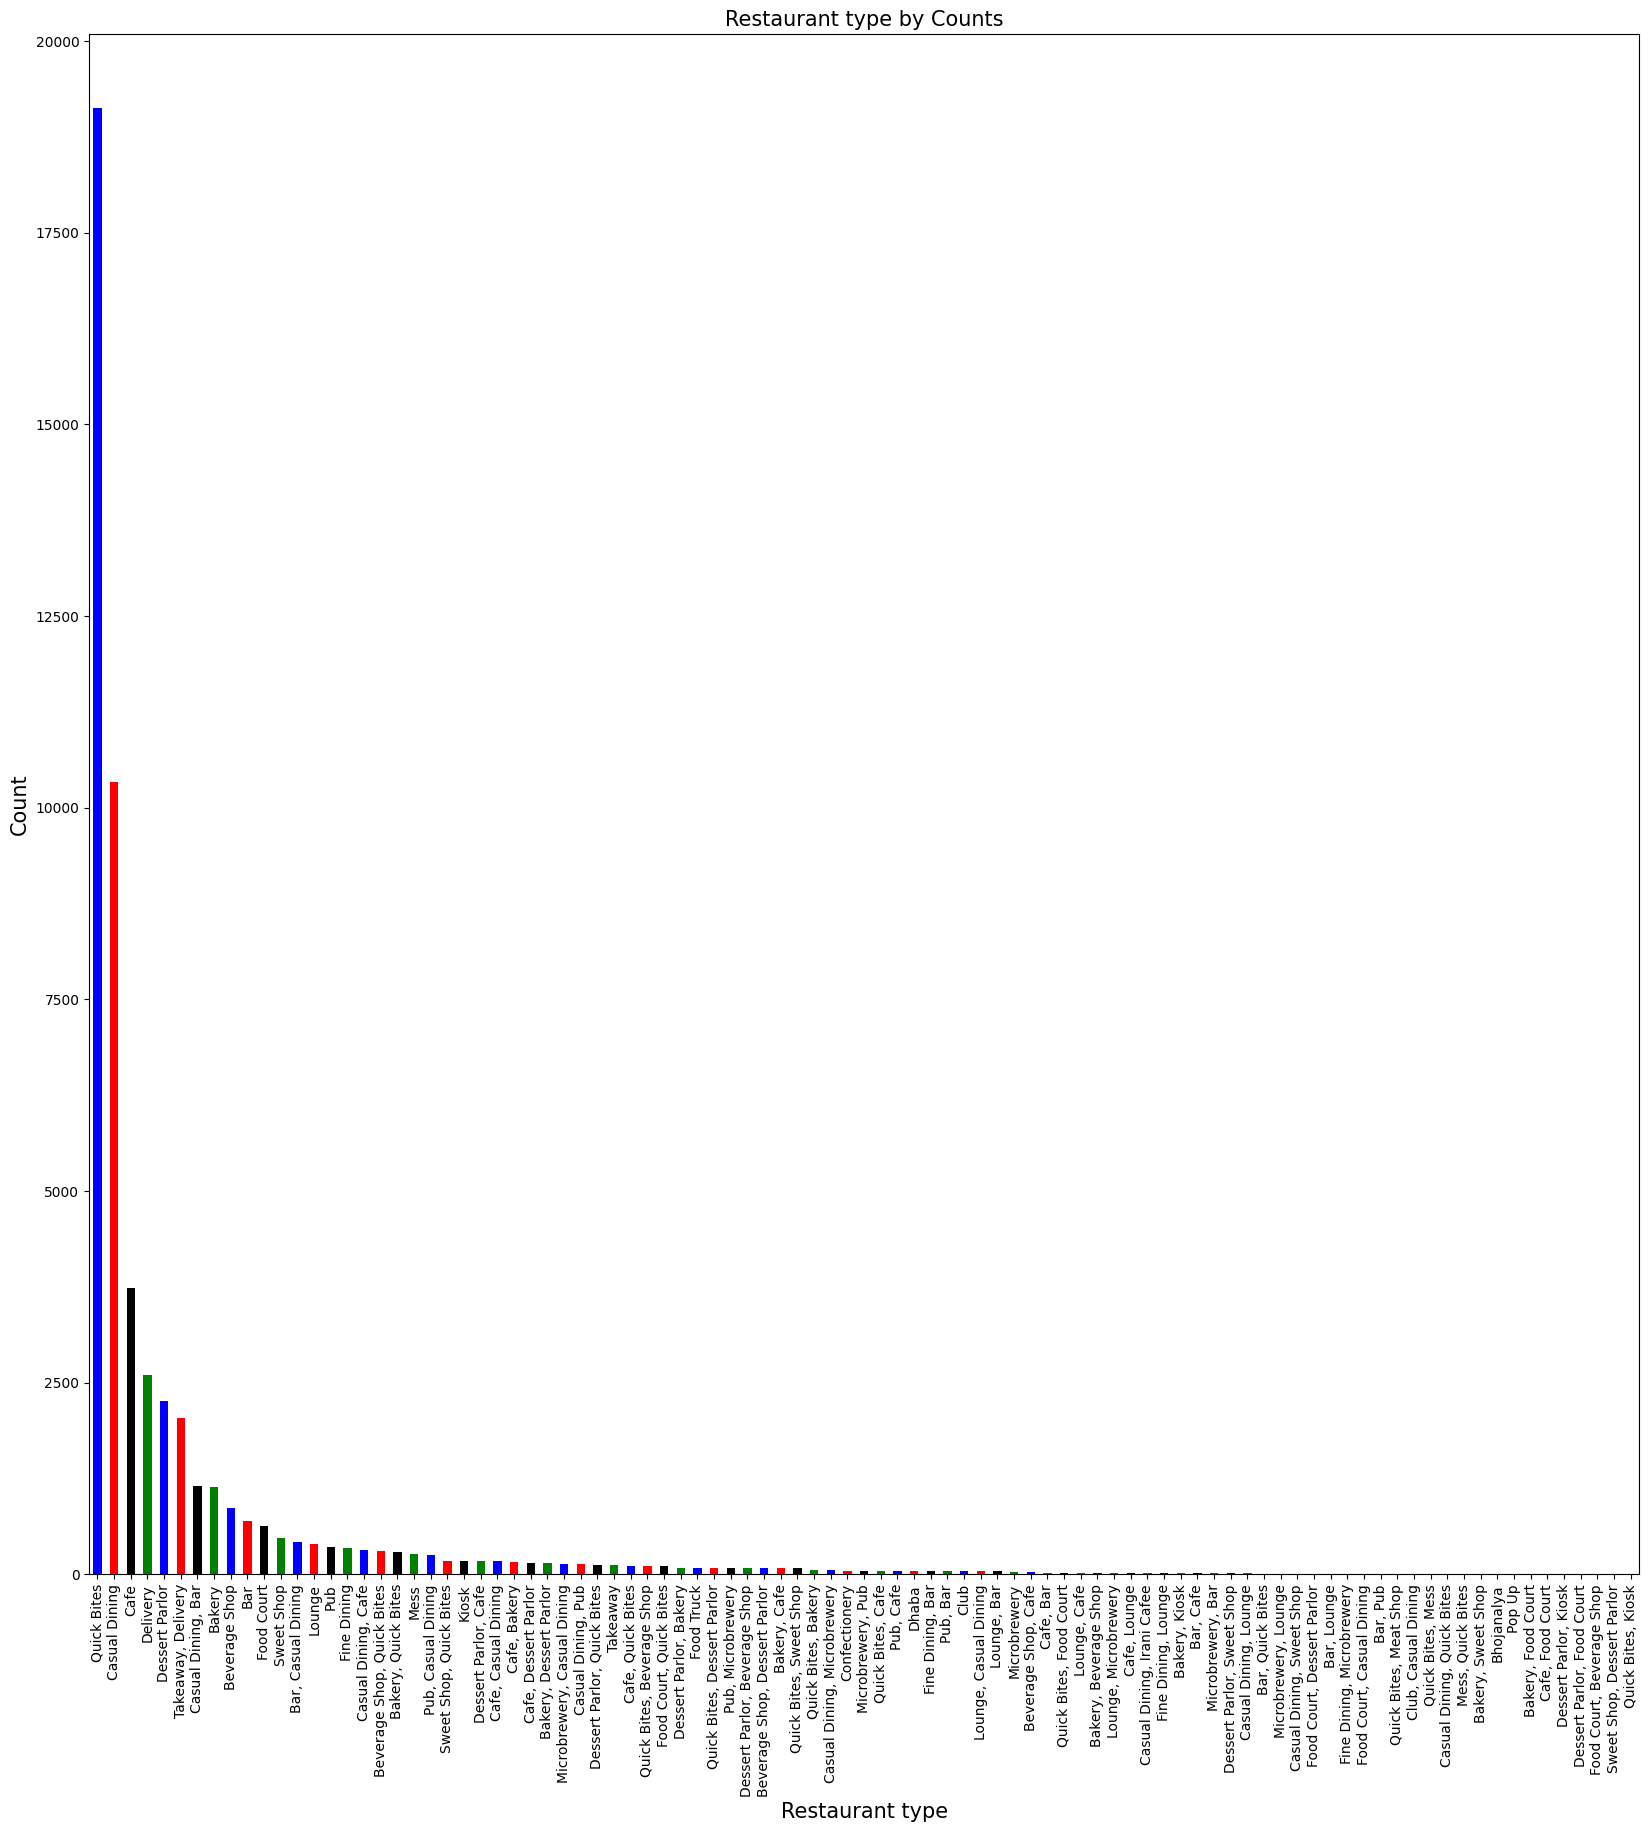

In [11]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
# Observation: Highest number of restaurant types are quick bytes.
data['rest_type'].value_counts().plot(kind = 'bar', fontsize = 10, 
                                      figsize=(20,20),color = ['b','r','k','g'])
plt.xlabel('Restaurant type', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Restaurant type by Counts',fontsize = 15)
plt.show()

Text(0.5, 1.0, 'Type of restaurants providing table booking facility')

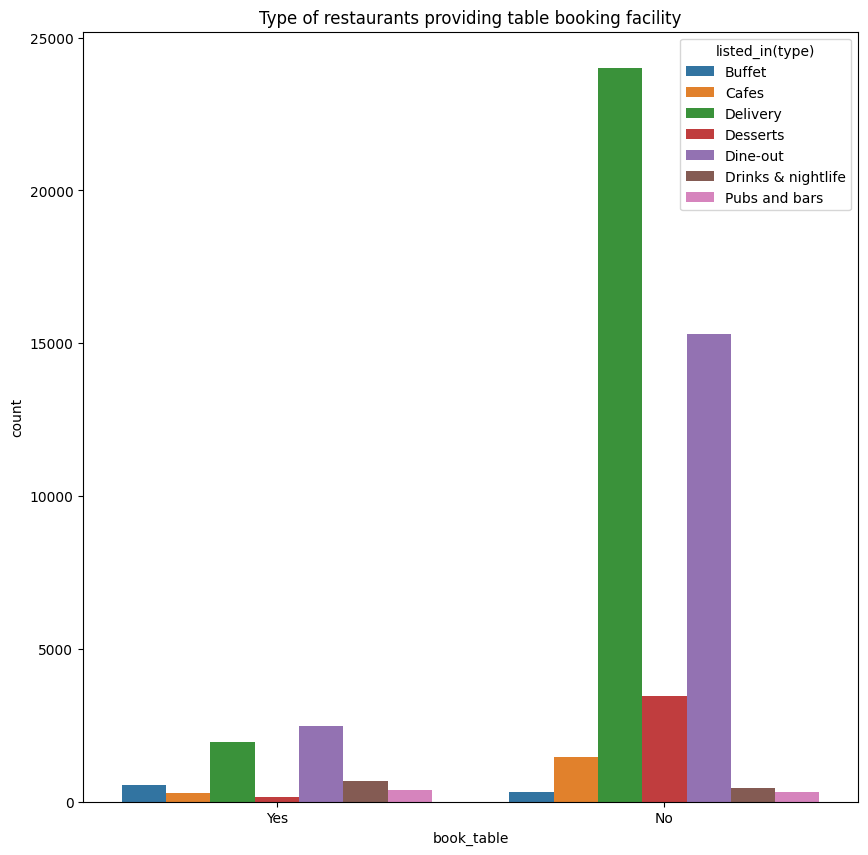

In [12]:
# https://www.kaggle.com/poojanagure/zomato-biginner-analysis
# Observation: The graph is ploted against restaurants offering/ not offering 
# online order facility. Most of restaurants which don't offer online order facility 
# are listed for delivery facility.
sns.countplot(x=data['book_table'],hue= data['listed_in(type)'])
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.title('Type of restaurants providing table booking facility')

### Process data

In [13]:
# Let's rename the some attributes of the dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
data=data.rename(columns={'approx_cost(for two people)':'approx_cost',
                          'listed_in(type)':'type','listed_in(city)':'city'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           51717 non-null  object
 1   address       51717 non-null  object
 2   name          51717 non-null  object
 3   online_order  51717 non-null  object
 4   book_table    51717 non-null  object
 5   rate          43942 non-null  object
 6   votes         51717 non-null  int64 
 7   phone         50509 non-null  object
 8   location      51696 non-null  object
 9   rest_type     51490 non-null  object
 10  dish_liked    23639 non-null  object
 11  cuisines      51672 non-null  object
 12  approx_cost   51371 non-null  object
 13  reviews_list  51717 non-null  object
 14  menu_item     51717 non-null  object
 15  type          51717 non-null  object
 16  city          51717 non-null  object
dtypes: int64(1), object(16)
memory usage: 6.7+ MB


In [14]:
# Attribute: Rate
'''The rate attribute has rating out of 5. So, we can change the data to only 
rate by removing /5 from the string. For that, let's remove /5 from the rate.
https://www.kaggle.com/virajbagal/foodie-s-eda-of-zomato'''

data['rate']=data['rate'].apply(lambda value: str(value).split('/')[0])


# Attribute: approx_cost 
'''In approx_cost attribute, many cells have more than 999 value and they have , 
in the data e.g. 1,500. Thus, comma(,) needs
to be removed.'''

data['approx_cost']=data['approx_cost'].apply(lambda x: str(x).replace(',',''))


# Attribute: rate 
'''Now, let's fill null of rate attributes to zero. The Zomato doesn't allow to add 
zero rate. Thus, it is vital to replace null values with zero.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html'''

data['rate'].fillna(0, inplace=True)

'''Replacing some non-required cells. In Zomato, it is not allowed to give rating as 0. 
Thus, I am replacing nan, NEW, - with 0.
# https://stackoverflow.com/a/51494058'''
data['rate'] = data['rate'].replace(regex='nan', value=0)
data['rate'] = data['rate'].replace(regex='NEW', value=0)
data['rate'] = data['rate'].replace(regex='-', value=0)


# Attribute: approx_cost
'''Deleting instances with approx_cost as nan'''

data=data[data['approx_cost']!='nan']


# Attribute: rate, vote, approx_cost
'''Converting rate, votes, and approx_cost to float and int'''

data['rate']=data['rate'].astype(float)
data['votes']=data['votes'].astype(int)
data['approx_cost']=data['approx_cost'].astype(int)


# Deciding about unnecessary attributes is covered after 2.c
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51371 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           51371 non-null  object 
 1   address       51371 non-null  object 
 2   name          51371 non-null  object 
 3   online_order  51371 non-null  object 
 4   book_table    51371 non-null  object 
 5   rate          51371 non-null  float64
 6   votes         51371 non-null  int64  
 7   phone         50497 non-null  object 
 8   location      51371 non-null  object 
 9   rest_type     51167 non-null  object 
 10  dish_liked    23503 non-null  object 
 11  cuisines      51352 non-null  object 
 12  approx_cost   51371 non-null  int64  
 13  reviews_list  51371 non-null  object 
 14  menu_item     51371 non-null  object 
 15  type          51371 non-null  object 
 16  city          51371 non-null  object 
dtypes: float64(1), int64(2), object(14)
memory usage: 7.1+ MB


In [15]:
# Restaurant duplicates in the data (2.c)

'''The 'name' attribute contains the name of the reastaurant. Thus, let's try 
to find find values counts to check if all the reastaurant names are unique. 
As shown in below output, all the restaurants are not unique as there are restaurants 
with name of outlets like Pizza Hut. They can have different locations.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html'''

data['name'].value_counts()

name
Cafe Coffee Day                 96
Onesta                          85
Just Bake                       73
Empire Restaurant               71
Five Star Chicken               70
                                ..
Angel's Kitchen                  1
Hunan Express                    1
Sri chowdeshwari Mudde Hotel     1
Mothi Restaurant                 1
Nalaas Aapakadai                 1
Name: count, Length: 8756, dtype: int64

In [16]:
'''There are many restaurant duplicates which need to be removed. To decide 
about which should be removed, I have sorted instances based upon 'votes' attribute. 
The higher votes indicate latest data and those data should be considered in analysis.
https://www.geeksforgeeks.org/python-pandas-dataframe-sort_values-set-1/'''

data.sort_values("votes", ascending = False, inplace = True) 

In [17]:
'''Now, let's keep first instance in duplicates as the instances are sorted in 
descending order and first instance indicates highest votes. The duplicates are 
removed based upon combination of name and address attributes.'''

data.drop_duplicates(subset=['name', 'address'], keep='first', inplace=True)

In [18]:
# Cheking the useless attributes
'''Let's count percentage of null values in each attributes
https://www.kaggle.com/virajbagal/foodie-s-eda-of-zomato'''

countNullPercentage(data)

'''Here, dish_liked has more than 51% instances as null. Thus, the dish_liked 
is useless at this time. In addition, url is also not useful for analysis as all 
values are unique and there will be no meaning in any analysis that can be done 
based upon consideting url restaurant in the website of Zomato. The phone attribute 
is not also useful for analysis as it doesn't need to be taken into consideration in 
building a model. '''

url              0.00
address          0.00
name             0.00
online_order     0.00
book_table       0.00
rate             0.00
votes            0.00
phone            1.78
location         0.00
rest_type        0.43
dish_liked      62.66
cuisines         0.07
approx_cost      0.00
reviews_list     0.00
menu_item        0.00
type             0.00
city             0.00
dtype: float64


"Here, dish_liked has more than 51% instances as null. Thus, the dish_liked \nis useless at this time. In addition, url is also not useful for analysis as all \nvalues are unique and there will be no meaning in any analysis that can be done \nbased upon consideting url restaurant in the website of Zomato. The phone attribute \nis not also useful for analysis as it doesn't need to be taken into consideration in \nbuilding a model. "

In [19]:
'''Let's delete null values from attribute rest_type and cuisines as those attributes 
might be useful building model. Here, phone and dish_liked also contains null values. 
But dish_liked has more than 51% cells as null. Thus, instead ofdeleting the instances, 
we can simply drop that attribute. The phone attribute won't be useful building a model.
Thus, deletion of instances with phone with null values is not required.'''

data.dropna(subset=['rest_type'], inplace=True)
data.dropna(subset=['cuisines'], inplace=True)

In [20]:
'''Now, null values from rest_type and cuisines are removed'''
countNullPercentage(data)

url              0.00
address          0.00
name             0.00
online_order     0.00
book_table       0.00
rate             0.00
votes            0.00
phone            1.77
location         0.00
rest_type        0.00
dish_liked      62.60
cuisines         0.00
approx_cost      0.00
reviews_list     0.00
menu_item        0.00
type             0.00
city             0.00
dtype: float64


In [21]:
# Neighborhood with highest average ratings (2.d)
'''Now, let's identify location with highest average rating, we shouldn't consider rates 
with 0 as they are 0 because of no data available (as shown in data processing step). 
Thus, I am replacing rates having 0.0 to nan so that they don't get included in 
calculation of average rating.'''

data['rate'].replace(0.0,np.nan, inplace=True)

In [22]:
'''Now, let's find location with highest average rating. To do so, the instances are 
grouped by location and mean of rate is calculated. The values are then sorted in 
descending order.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html'''
answer = data.groupby('location')['rate'].mean().sort_values(ascending = False)

'''Convert answer to dataframe to extract location name from the answer.
https://stackoverflow.com/a/26098292'''
df = pd.DataFrame({'location': answer.index, 'rating-avg': answer.values})
highest_average_data=data[data['location']==df['location'][0]]

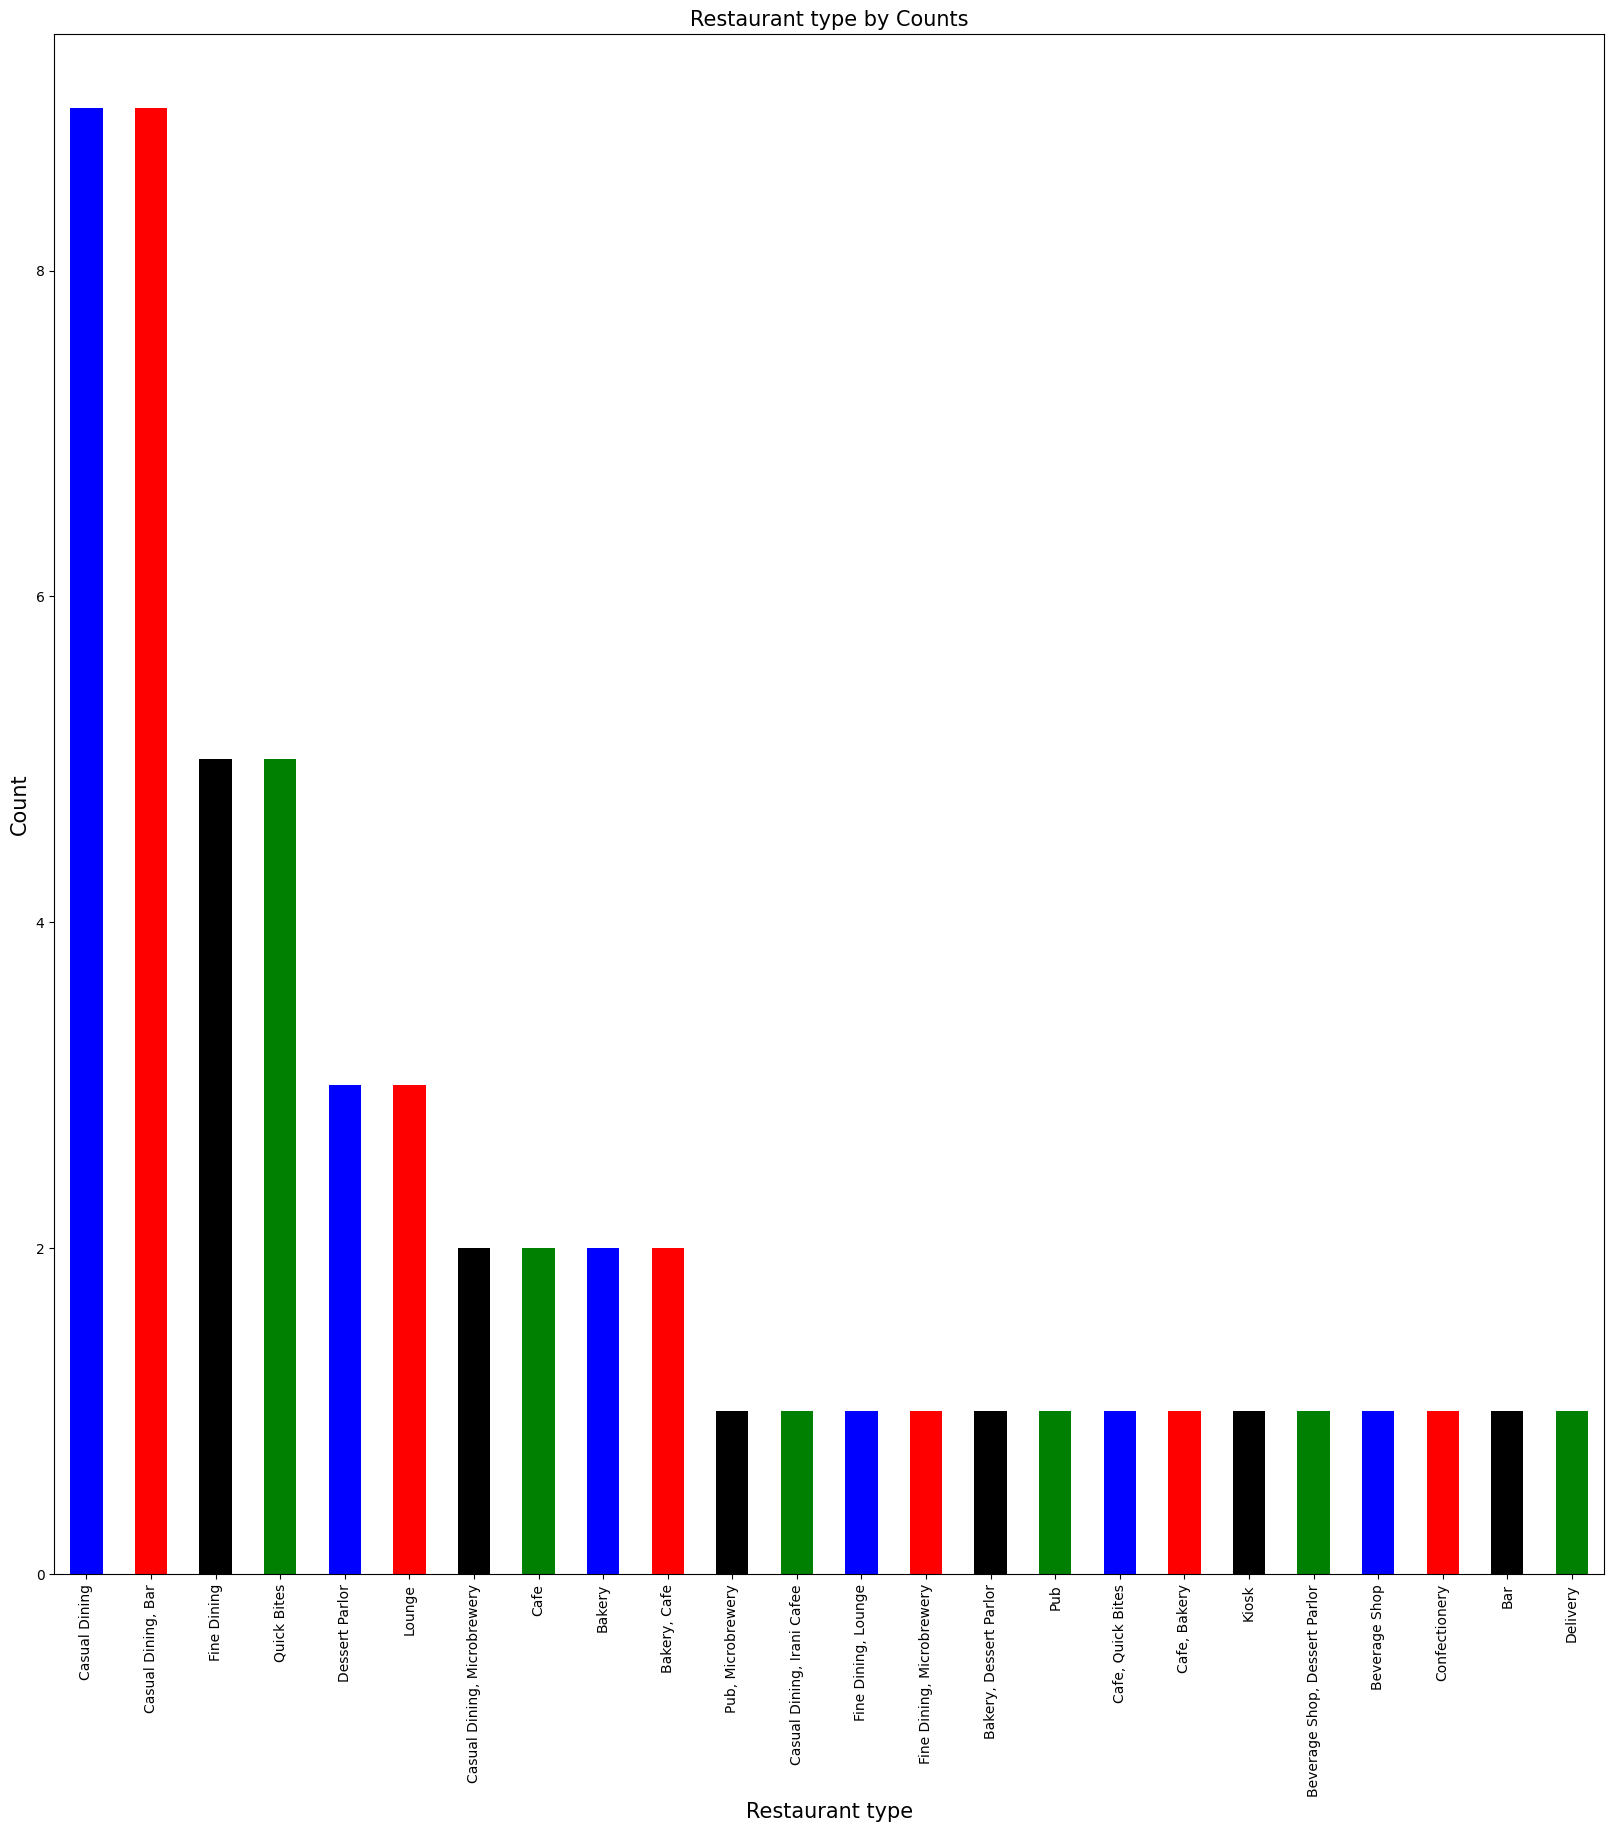

In [23]:
'''Now let's check what restaurant types are there in this location
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html'''

highest_average_data['rest_type'].value_counts().plot(kind = 'bar', fontsize = 10, 
                                    figsize=(20,20),color = ['b','r','k','g'])
plt.xlabel('Restaurant type', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Restaurant type by Counts',fontsize = 15)
plt.show()

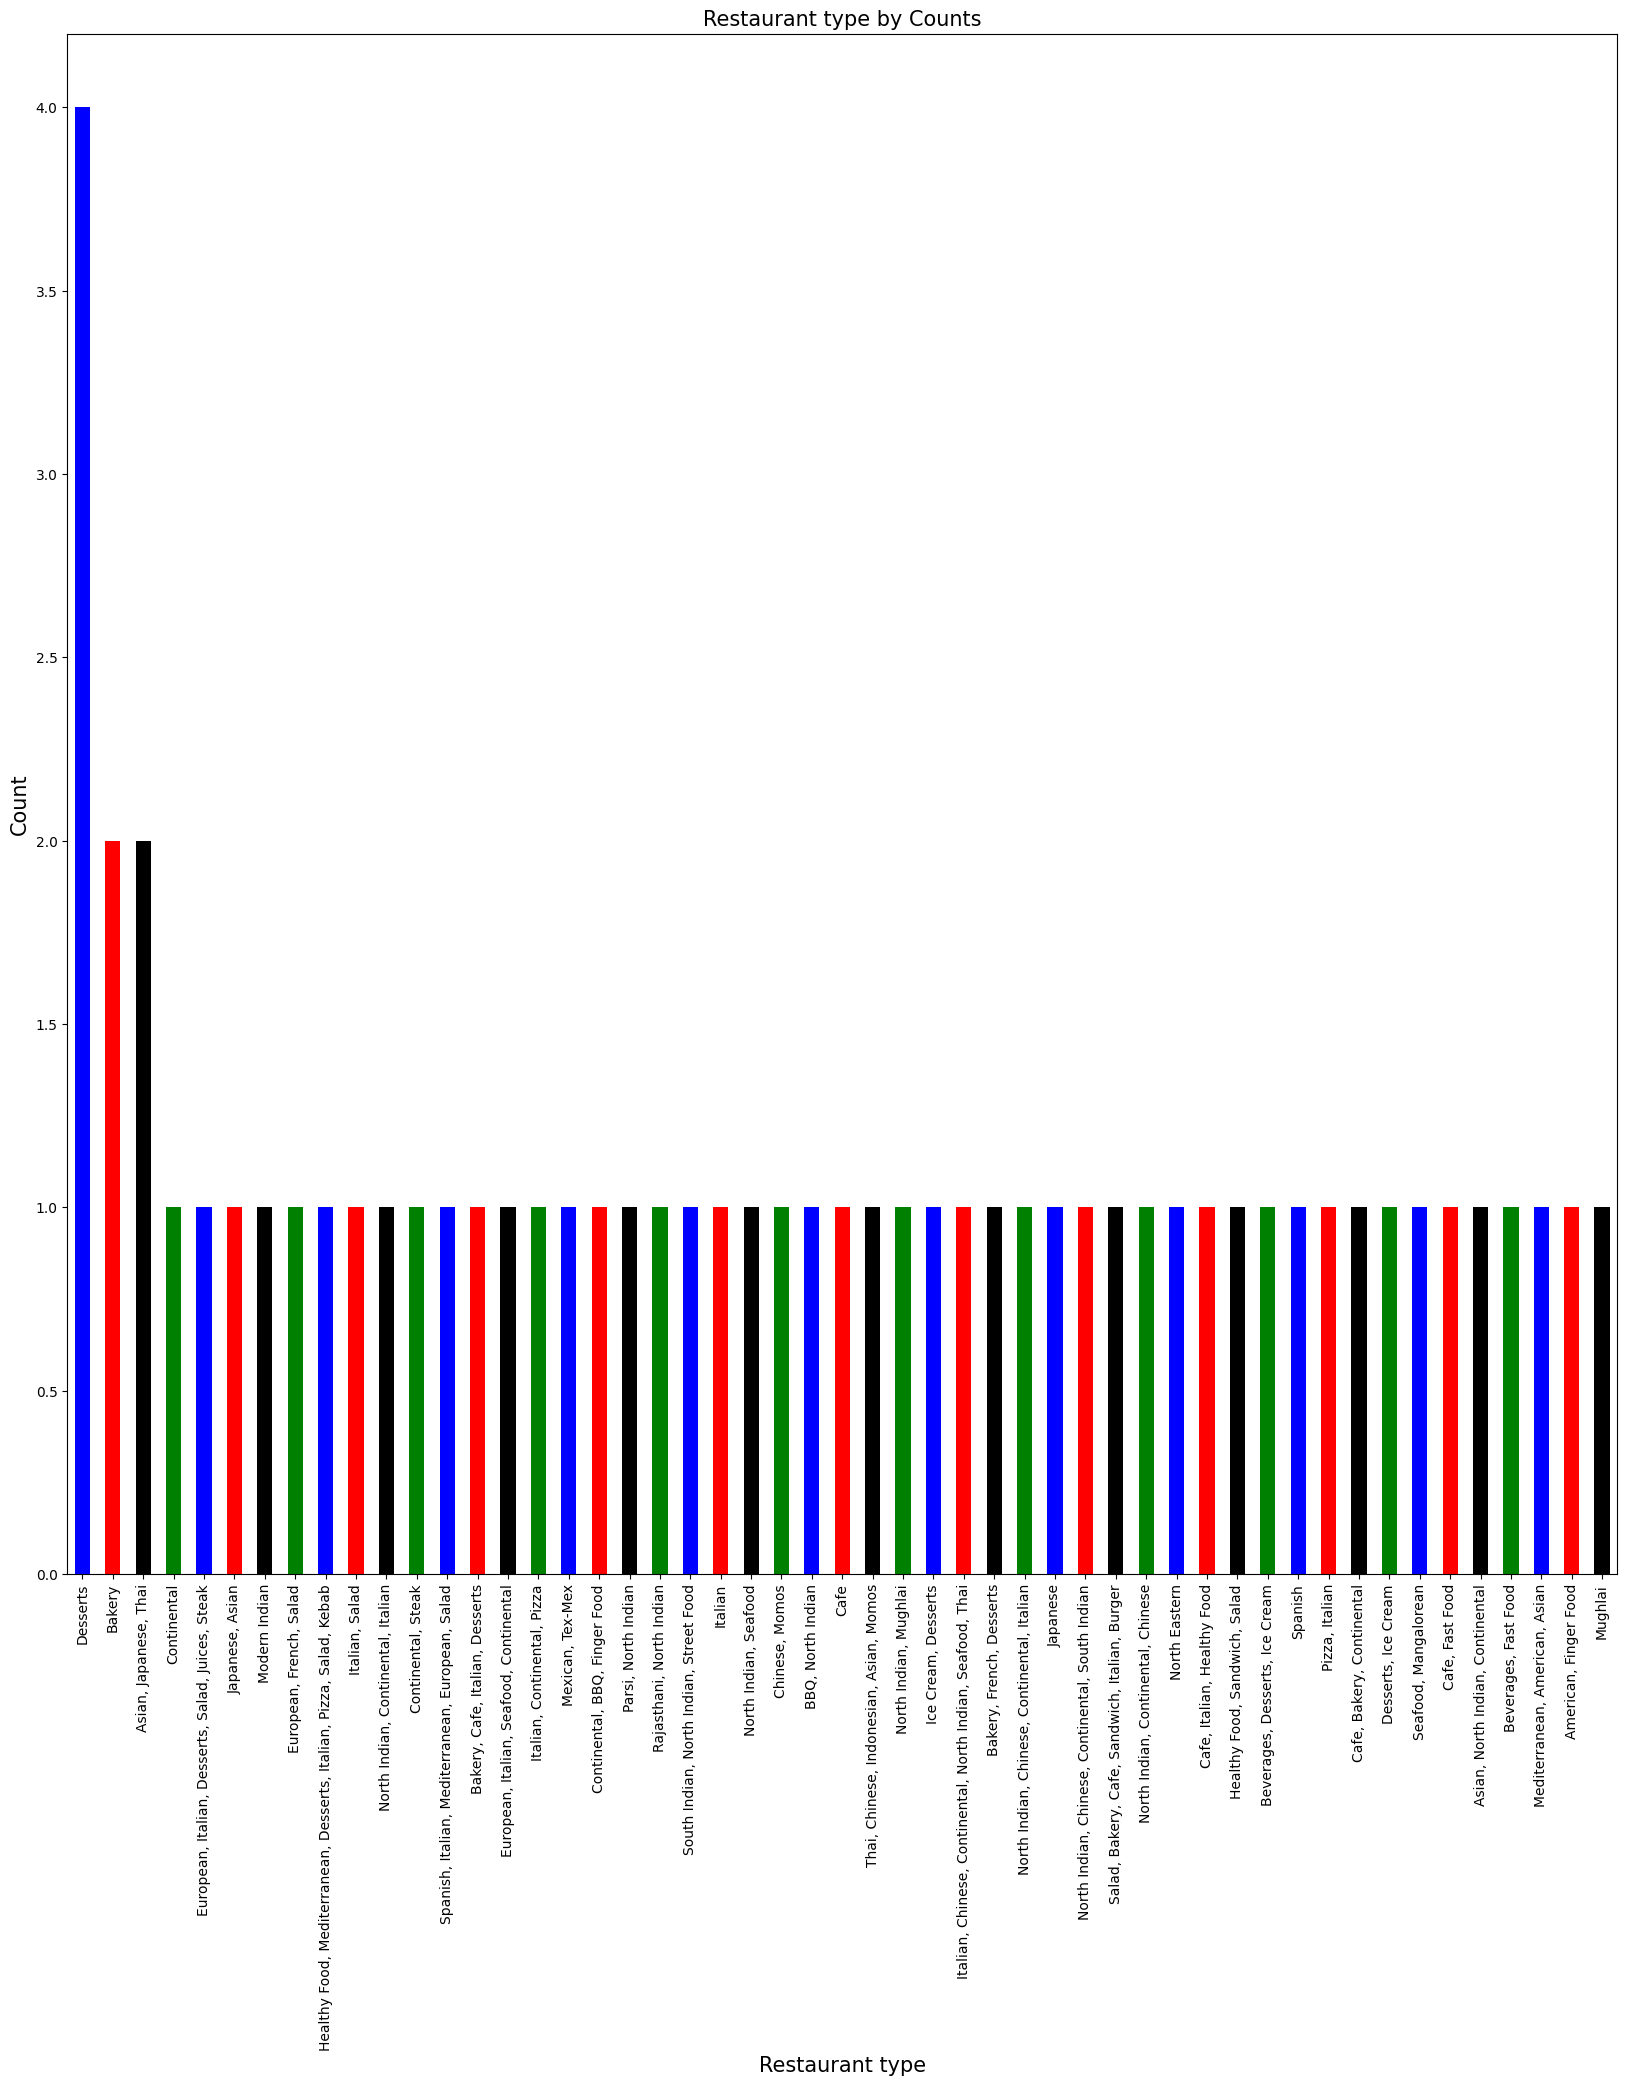

In [24]:
'''Now let's check what cuisines are offered in this location
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html'''

highest_average_data['cuisines'].value_counts().plot(kind = 'bar', fontsize = 10, 
                                        figsize=(20,20),color = ['b','r','k','g'])
plt.xlabel('Restaurant type', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Restaurant type by Counts',fontsize = 15)
plt.show()

In [25]:
'''Now, let's replace rates with nan to 0.0 again.'''
data['rate'].replace(np.nan,0.0, inplace = True)

### Build models

In [26]:
# 3.a
'''
The task here is to find approximate cost of a meal for two people. The attributes 
to use are location, rating, restaurant type and cuisine. Thus, it is a supervised 
technique as we have target attribute value as approximate cost. In addition, the 
approximate cost has values in continues manner. Thus, the type is regression. 
By using location, rating, restaurant type and cuisine (independent variables); we want 
to predict approx meal cost for two people (dependent variable).
'''

'\nThe task here is to find approximate cost of a meal for two people. The attributes \nto use are location, rating, restaurant type and cuisine. Thus, it is a supervised \ntechnique as we have target attribute value as approximate cost. In addition, the \napproximate cost has values in continues manner. Thus, the type is regression. \nBy using location, rating, restaurant type and cuisine (independent variables); we want \nto predict approx meal cost for two people (dependent variable).\n'

In [27]:
# 3.b
'''We are using regression models as the target attribute has continues values.
We will be using,

1. Decision Tree regression: Decision trees are easy to interprete and can split 
data according to attribute dependentacy towards target attribute. The reason to 
use decision tree regression is that the values in target attribute are continues.

2. Random forest regression: The main reason to use Random forest in place of 
Decision tree is that  we can add multiple trees in our forest and that can increase 
the performance compared to a single decision tree. 

3. XGBoost regression: The prime reason for using XGBoost its execution speed and 
the performance of the model. The time taken by the XGBoost by the large dataset is 
comparatively simpler and faster. Also, compared to linear regression and other 
basic regression models like simple Gradient Boosting, XGBoost regressor will 
perform well and R2 score for testing data will be higher.
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
'''

'We are using regression models as the target attribute has continues values.\nWe will be using,\n\n1. Decision Tree regression: Decision trees are easy to interprete and can split \ndata according to attribute dependentacy towards target attribute. The reason to \nuse decision tree regression is that the values in target attribute are continues.\n\n2. Random forest regression: The main reason to use Random forest in place of \nDecision tree is that  we can add multiple trees in our forest and that can increase \nthe performance compared to a single decision tree. \n\n3. XGBoost regression: The prime reason for using XGBoost its execution speed and \nthe performance of the model. The time taken by the XGBoost by the large dataset is \ncomparatively simpler and faster. Also, compared to linear regression and other \nbasic regression models like simple Gradient Boosting, XGBoost regressor will \nperform well and R2 score for testing data will be higher.\nhttps://machinelearningmastery.co

In [28]:
# 3.c
'''We will be using R-squared and Mean Absolute Error (MAE) to check performance of the models.

R-squared:
https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit
It is the percentage of the response variable variation that is explained by a model.
R-squared is always between 0 and 100%

0% indicates that the model explains none of the variability of the response data 
around its mean. 100% indicates that the model explains all the variability of the 
response data around its mean.

Thus, our goal will be to gain higher r2_score.

Mean Absolute Error(MAE):
https://becominghuman.ai/understand-regression-performance-metrics-bdb0e7fcc1b3
The Mean Absolute Error measures the average of the absolute difference between each 
ground truth and the predictions. As it calculates absolute difference between actual 
value and predicted value, it will be less sensitive to outliers as compared to Mean 
Sqaured Error(MSE) which calculared square of difference.

We will also use learning curves to check how the model is permorming with different 
number of instances. It can also help to check how many number of input instances are 
required to get a good trained model. The learning curves will be plloted with cross 
validation and r2 score parametes.
https://scikit-learn.org/stable/modules/learning_curve.html
'''

'We will be using R-squared and Mean Absolute Error (MAE) to check performance of the models.\n\nR-squared:\nhttps://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit\nIt is the percentage of the response variable variation that is explained by a model.\nR-squared is always between 0 and 100%\n\n0% indicates that the model explains none of the variability of the response data \naround its mean. 100% indicates that the model explains all the variability of the \nresponse data around its mean.\n\nThus, our goal will be to gain higher r2_score.\n\nMean Absolute Error(MAE):\nhttps://becominghuman.ai/understand-regression-performance-metrics-bdb0e7fcc1b3\nThe Mean Absolute Error measures the average of the absolute difference between each \nground truth and the predictions. As it calculates absolute difference between actual \nvalue and predicted value, it will be less sensitive to outliers as compared to Mean \n

In [29]:
# 3.d
'''
https://www.ismll.uni-hildesheim.de/lehre/ml-08w/skript/decision_trees2.pdf
To avoid the overfitting, we will use pre-pruning technique. We need to specify 
maximum depth. The algorithm will stop the tree from growing more if maximum 
depth is reached. It will stop the nodes from splitting more and making the model 
overfitting. If we allow the tree to grow as more as it wants, it will split the 
nodes maximally and it will result in overfitting the model.
'''

'\nhttps://www.ismll.uni-hildesheim.de/lehre/ml-08w/skript/decision_trees2.pdf\nTo avoid the overfitting, we will use pre-pruning technique. We need to specify \nmaximum depth. The algorithm will stop the tree from growing more if maximum \ndepth is reached. It will stop the nodes from splitting more and making the model \noverfitting. If we allow the tree to grow as more as it wants, it will split the \nnodes maximally and it will result in overfitting the model.\n'

In [30]:
# 3.e
'''https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
The model is to be built based upon location, rating, restaurant type, cuisine 
as feature vectors and approx_cost as target attribute. Thus, let's keep only 
those attributes in the data.'''

data_new = data[['rest_type','cuisines','location','rate','approx_cost']]
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12381 entries, 50059 to 51627
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rest_type    12381 non-null  object 
 1   cuisines     12381 non-null  object 
 2   location     12381 non-null  object 
 3   rate         12381 non-null  float64
 4   approx_cost  12381 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 580.4+ KB


In [31]:
# https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns

data_new

,rest_type,cuisines,location,rate,approx_cost
50059,Microbrewery,"Continental, North Indian, Italian, South Indi...",Sarjapur Road,4.9,1600
19268,Microbrewery,"Italian, American, Pizza",Indiranagar,4.7,1500
36668,"Cafe, Casual Dining","Cafe, American, Burger, Steak",Koramangala 5th Block,4.7,900
41525,Casual Dining,"European, Mediterranean, North Indian, BBQ",Marathahalli,4.8,1600
37606,"Casual Dining, Bar","North Indian, European, Mediterranean",Koramangala 5th Block,4.7,1400
...,...,...,...,...,...
3211,Dessert Parlor,"Desserts, Ice Cream",Basavanagudi,0.0,150
3212,Bakery,"Bakery, Mithai",Basavanagudi,0.0,500
3216,"Sweet Shop, Dessert Parlor","Mithai, Desserts, Bakery",Basavanagudi,0.0,100
51714,Bar,Finger Food,Whitefield,0.0,2000


In [32]:
# Dividing the new data set into feature and target and taking only their values

features = data_new[['rest_type','cuisines','location','rate']]
target = data_new[['approx_cost']].values
rate_attibute = data_new[['rate']].values

In [33]:
features

,rest_type,cuisines,location,rate
50059,Microbrewery,"Continental, North Indian, Italian, South Indi...",Sarjapur Road,4.9
19268,Microbrewery,"Italian, American, Pizza",Indiranagar,4.7
36668,"Cafe, Casual Dining","Cafe, American, Burger, Steak",Koramangala 5th Block,4.7
41525,Casual Dining,"European, Mediterranean, North Indian, BBQ",Marathahalli,4.8
37606,"Casual Dining, Bar","North Indian, European, Mediterranean",Koramangala 5th Block,4.7
...,...,...,...,...
3211,Dessert Parlor,"Desserts, Ice Cream",Basavanagudi,0.0
3212,Bakery,"Bakery, Mithai",Basavanagudi,0.0
3216,"Sweet Shop, Dessert Parlor","Mithai, Desserts, Bakery",Basavanagudi,0.0
51714,Bar,Finger Food,Whitefield,0.0


In [34]:
'''
The rest_type and cuisines attributes contain string with many types of 
restaurant and cuisines appended by comma(,). The restaurant types and 
cuisines may affect the approximate cost of meal. Thus, to make the model 
more accurate, we can seperate the string by commas and make a single 
attribute with rest_type  and cuisines name. For example consider two 
instances with restaurant type as A,B,C and A,C. After transformation, 
we want three attributes created namely A, B and C. The features with 
instances will be as below.
A   B   C
1   1   1
1   0   1
'''

# Split string in rest_type and cuisines to list
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
transform_rest_type = features.iloc[:,0].str.split(", ")   # Each instance will have a list with rest_type. exa. [A,B,C]
transform_cuisines = features.iloc[:,1].str.split(", ")

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
#Each instance in location attributes has only one srting associated 
# with it. Thus, we can use label encoder for that attribute.
encode_location = preprocessing.LabelEncoder()
features["location"] = encode_location.fit_transform(features["location"])

In [35]:
# We can use MultiLabelBinarizer to convert list to attributes and to 
# assign 0 and 1 if it is not/ is present. 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
multiLabelBinarizer_rest_type = MultiLabelBinarizer()
df_rest_type = pd.DataFrame(
    multiLabelBinarizer_rest_type.fit_transform(transform_rest_type),
    columns=multiLabelBinarizer_rest_type.classes_, index=features.index)
df_rest_type.head()

,Bakery,Bar,Beverage Shop,Bhojanalya,Cafe,Casual Dining,Club,Confectionery,Delivery,Dessert Parlor,...,Kiosk,Lounge,Meat Shop,Mess,Microbrewery,Pop Up,Pub,Quick Bites,Sweet Shop,Takeaway
50059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
36668,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41525,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37606,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Renaming Bakery and cafe attributes as they are also available in cuisines. 
# It could create problems in models
df_rest_type=df_rest_type.rename(columns={'Bakery':'Bakery_rest_type',
                                          'Cafe':'Cafe_rest_type'})

In [37]:
multiLabelBinarizer_cuisines = MultiLabelBinarizer()
df_cuisines = pd.DataFrame(
    multiLabelBinarizer_cuisines.fit_transform(transform_cuisines),
    columns=multiLabelBinarizer_cuisines.classes_, index=features.index)
df_cuisines.head()

,Afghan,Afghani,African,American,Andhra,Arabian,Asian,Assamese,Australian,Awadhi,...,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vegan,Vietnamese,Wraps
50059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19268,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36668,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Renaming Bakery and cafe attributes as they are also available in rest_type. 
# It could create problems in models
df_cuisines=df_cuisines.rename(columns={'Bakery':'Bakery_cuisines',
                                        'Cafe':'Cafe_cuisines'})

In [39]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
features = pd.concat([features['location'], features['rate'], df_rest_type, 
                      df_cuisines], axis=1, sort=False)

In [40]:
features

,location,rate,Bakery_rest_type,Bar,Beverage Shop,Bhojanalya,Cafe_rest_type,Casual Dining,Club,Confectionery,...,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vegan,Vietnamese,Wraps
50059,76,4.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19268,27,4.7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36668,45,4.7,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
41525,56,4.8,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
37606,45,4.7,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,4,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3212,4,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3216,4,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51714,89,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# 3.e and 3.f
# Let's split data into training and testing set. The testing set is 30%.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                            test_size = 0.3, random_state = 90)

In [42]:
# Let's train the model using DecisionTreeRegressor
# http://www.semspirit.com/artificial-intelligence/machine-learning/regression/decision-tree-regression/decision-tree-regression-in-python/
# To avoid overfitting, we have used max_depth parameter which is also 
# a pre-pruning approach. Right now, the max_depth is just random guess. 
# To improve the performance of model, we can adapt the better max_depth 
# using parameter tuning.

decision_tree_regressor = DecisionTreeRegressor(max_depth=5)
decision_tree_regressor.fit(X_train, y_train)
y_pred_dtr = decision_tree_regressor.predict(X_test)

In [43]:
# Let's check r2_score, MAE of the DecisionTreeRegressor model
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

model_scores = []   # This list will be used in table plotting at the end.

DTR_scores_before_pruning = []
DTR_scores_before_pruning.append('DecisionTreeRegressor(before pruning)')
DTR_scores_before_pruning.append(metrics.mean_absolute_error(y_train, 
                            decision_tree_regressor.predict(X_train)))
DTR_scores_before_pruning.append(metrics.mean_absolute_error(y_test, y_pred_dtr))
DTR_scores_before_pruning.append(r2_score(y_train, 
                            decision_tree_regressor.predict(X_train)))
DTR_scores_before_pruning.append(r2_score(y_test, y_pred_dtr))
model_scores.append(DTR_scores_before_pruning)

print("-----DECISION TREE REGRESSOR EVALUATION-----")
print("MAE train: %f" % DTR_scores_before_pruning[1])
print("MAE test: %f" % DTR_scores_before_pruning[2])
print("R2 train : %f" % DTR_scores_before_pruning[3])
print("R2 test : %f" % DTR_scores_before_pruning[4])

-----DECISION TREE REGRESSOR EVALUATION-----
MAE train: 149.212166
MAE test: 154.443372
R2 train : 0.706675
R2 test : 0.692410


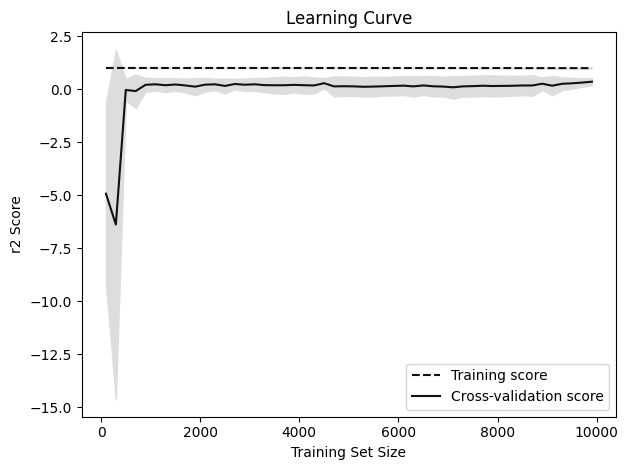

In [44]:
'''
Now, let's plot learning curves for Decision Tree Regressor. We have 
passed r2 scoring and 10 folds for cross validation. The train sizes 
are from 0.01 to 1.0 in 50 intervals. From plot, we can identify how 
the model performs with different number of sets. We can also check 
from how many number of instances, the model perform well. The number 
of instances from which the cross-validation curve starts stabling, can 
be considered to be enough points to train the model.
'''
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeRegressor(), features, target, cv=5, 
    scoring='r2',n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, 
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, 
                 test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("r2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [45]:
# Let's train the model using RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# To avoid overfitting, we have used max_depth parameter which is also 
# a pre-pruning approach. Right now, the max_depth is just random guess. 
# To improve the performance of model, we can adapt the better max_depth 
# using parameter tuning.

random_forest_regressor = RandomForestRegressor(n_estimators=50, 
                                                max_depth=12)  
random_forest_regressor.fit(X_train, np.ravel(y_train))  # https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
y_pred_rfr = random_forest_regressor.predict(X_test) 

In [46]:
# Let's check r2_score, MAE of the RandomForestRegressor model

RFR_scores_before_pruning = []

RFR_scores_before_pruning.append('RandomForestRegressor(before pruning)')
RFR_scores_before_pruning.append(metrics.mean_absolute_error(y_train, 
                                    random_forest_regressor.predict(X_train)))
RFR_scores_before_pruning.append(metrics.mean_absolute_error(y_test, y_pred_rfr))
RFR_scores_before_pruning.append(r2_score(y_train, 
                                    random_forest_regressor.predict(X_train)))
RFR_scores_before_pruning.append(r2_score(y_test, y_pred_rfr))
model_scores.append(RFR_scores_before_pruning)

print("-----RANDOM FOREST REGRESSOR EVALUATION-----")
print("MAE train: %f" % RFR_scores_before_pruning[1])
print("MAE test: %f" % RFR_scores_before_pruning[2])
print("R2 train : %f" % RFR_scores_before_pruning[3])
print("R2 test : %f" % RFR_scores_before_pruning[4])

-----RANDOM FOREST REGRESSOR EVALUATION-----
MAE train: 108.161965
MAE test: 130.496613
R2 train : 0.863728
R2 test : 0.766831


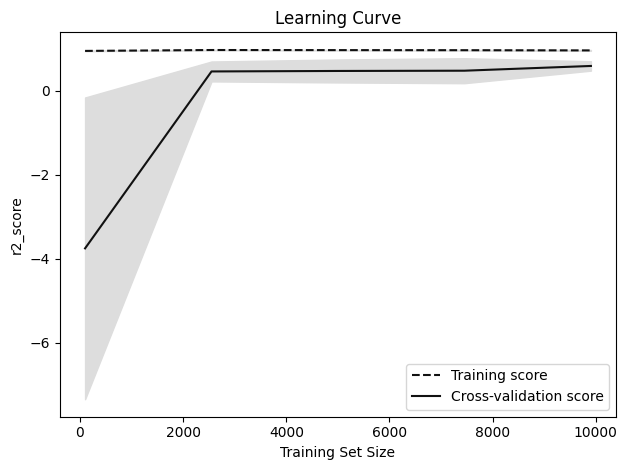

In [47]:
'''
Now, let's plot learning curves for Random Forest Regressor. We have 
passed r2 scoring and 10 folds for cross validation. The train sizes 
are from 0.01 to 1.0 in 5 intervals. From plot, we can identify how 
the model performs with different number of sets. We can also check 
from how many number of instances, the model perform well. The number 
of instances from which the cross-validation curve starts stabling, 
can be considered to be enough points to train the model.

We can plot the model with more number of folds and intervals. As it 
takes more execution time for more train_sizes, wehava plotted for 5 
train_sizes only.
'''
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
train_sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(), 
    features, target, cv=5, scoring='r2',
    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 5))


# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  
         label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", 
         label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, 
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, 
                 test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("r2_score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [48]:
# Let's train the model using DecisionTreeRegressor and check 
# r2_score of the model
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
# To avoid overfitting, we have used max_depth parameter which is 
# also a pre-pruning approach. Right now, the max_depth is just 
# random guess. To improve the performance of model, we can 
# adapt the better max_depth using parameter tuning.

XGBoost_regressor = xgboost.XGBRegressor(max_depth=12)
XGBoost_regressor.fit(X_train, y_train)
y_pred_XGB = XGBoost_regressor.predict(X_test)

In [49]:
# Let's check r2_score, MAE of the RandomForestRegressor model

XGB_scores_before_pruning = []
XGB_scores_before_pruning.append('XGBRegressor(before pruning)')
XGB_scores_before_pruning.append(metrics.mean_absolute_error(y_train, 
                                XGBoost_regressor.predict(X_train)))
XGB_scores_before_pruning.append(
    metrics.mean_absolute_error(y_test, y_pred_XGB))
XGB_scores_before_pruning.append(r2_score(y_train, 
                        XGBoost_regressor.predict(X_train)))
XGB_scores_before_pruning.append(r2_score(y_test, y_pred_XGB))
model_scores.append(XGB_scores_before_pruning)

print("-----XGBoost REGRESSOR EVALUATION-----")
print("MAE train: %f" % XGB_scores_before_pruning[1])
print("MAE test: %f" % XGB_scores_before_pruning[2])
print("R2 train : %f" % XGB_scores_before_pruning[3])
print("R2 test : %f" % XGB_scores_before_pruning[4])

-----XGBoost REGRESSOR EVALUATION-----
MAE train: 39.255505
MAE test: 128.006653
R2 train : 0.975153
R2 test : 0.721550


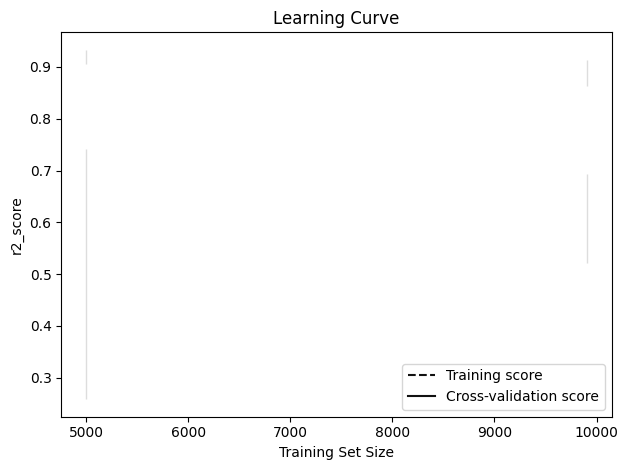

In [50]:
'''
Now, let's plot learning curves for XGBoost regressor. We have 
passed r2 scoring and 5 folds for cross validation. The train 
sizes are from 0.01 to 1.0 in 5 intervals. From plot, we can 
identify how the model performs with different number of sets. 
We can also check from  how many number of instances, the model 
perform well. The number of instances from which the cross-validation 
curve starts stabling, can be considered to be enough points to train 
the model.

We can plot the model with more number of folds and intervals. 
As it takes more execution time for more train_sizes, we 
hava plotted for 5 train_sizes only.
'''
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
train_sizes, train_scores, test_scores = learning_curve(xgboost.XGBRegressor(), features, 
    target, cv=5, scoring='r2',
    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 5))


# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  
         label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", 
         label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, 
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, 
                 test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("r2_score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Tuning the models

In [51]:
# 3.g

# Tuning Decision Tree
'''
https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
In order to tune the decision tree, we can specify some parametes 
in building the model. Using best combination of parameters, we 
can train the model. This model will give better accuracy as 
better combination of parameters is used while building the model.

For tuning the decision tree, we have specified range of values 
for max_depth parameter. In addition, 5 folds for CV and 
scoring method r2 is specified. The Grid search will check 
for best combination of parameters and those parameters will be 
used to build the model.

It should be noted that all parameters like min_samples_split, 
min_samples_leaf etc can also be added to param_grid in order 
to get best combination of parameters. However, it requires 
large computation power in order to get output quickly. Thus, 
we have used range of max_depth only to show parameter tuning 
approach here.

r2_score, MAE is calculated for the model which is built by using 
best parameters.
'''

def dtr_model(X, y):
    gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid={
            'max_depth': range(3,30),
        },
        cv=5, scoring='r2')
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print("Best parameters: ", best_params)
    
    dtr = DecisionTreeRegressor(max_depth=best_params["max_depth"])
    dtr.fit(X, np.ravel(y))
    scores = []
    scores.append(metrics.mean_absolute_error(y, dtr.predict(X)))
    scores.append(metrics.mean_absolute_error(y_test, 
                                              dtr.predict(X_test)))
    scores.append(r2_score(y, dtr.predict(X)))
    scores.append(r2_score(y_test,dtr.predict(X_test)))

    return scores

scores_dtr = dtr_model(X_train, np.ravel(y_train))
DTR_scores_after_pruning = []
DTR_scores_after_pruning.append('DecisionTreeRegressor(after pruning)')
for i in scores_dtr:
    DTR_scores_after_pruning.append(i)
    
model_scores.append(DTR_scores_after_pruning)
print("MAE train: %f" % DTR_scores_after_pruning[1])
print("MAE test: %f" % DTR_scores_after_pruning[2])
print("R2 train : %f" % DTR_scores_after_pruning[3])
print("R2 test : %f" % DTR_scores_after_pruning[4])

Best parameters:  {'max_depth': 8}
MAE train: 129.909004
MAE test: 148.362777
R2 train : 0.796927
R2 test : 0.692629


In [52]:
# Tuning Random forest regressor
'''
https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
In order to tune the random forest regressor, we can specify 
some parametes in building the model. Using best combination 
of parameters, we can train the model. This model will give 
better accuracy as better combination of parameters is used 
while building the model.

For tuning the random forest regressor, we have specified range 
of values for max_depth, n_estimators parameters. In addition, 
5 folds for  CV and scoring method r2 is specified. The Grid search 
will check for best combination of parameters and those parameters 
will be used to build the model.

It should be noted that all parameters like min_samples_split, 
min_samples_leaf etc can also be added to param_grid in order to 
get best combination of parameters. However, it requires large 
computation power in order to get output quickly. Thus, we have used 
range of max_depth, n_estimators only to show parameter tuning approach here.

r2_score, MAE is calculated for the model which is built by using best 
parameters.
'''

def rfr_model(X, y):
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': [4,7,10,12,20,50,75,100],
            'n_estimators': [10,20,40,50,60,80,90,100],
        },
        cv=5, scoring='r2')
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print("Best parameters: ", best_params)
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], 
                    n_estimators=best_params["n_estimators"], 
                    random_state=False, verbose=False)
    rfr.fit(X, np.ravel(y))
    scores = []
    scores.append(metrics.mean_absolute_error(y, rfr.predict(X)))
    scores.append(metrics.mean_absolute_error(y_test, 
                                              rfr.predict(X_test)))
    scores.append(r2_score(y, rfr.predict(X)))
    scores.append(r2_score(y_test,rfr.predict(X_test)))

    return scores

scores_rfr = rfr_model(X_train, np.ravel(y_train))
RFR_scores_after_pruning = []
RFR_scores_after_pruning.append('RandomForestRegressor(after pruning)')
for i in scores_rfr:
    RFR_scores_after_pruning.append(i)
    
model_scores.append(RFR_scores_after_pruning)
print("MAE train: %f" % RFR_scores_after_pruning[1])
print("MAE test: %f" % RFR_scores_after_pruning[2])
print("R2 train : %f" % RFR_scores_after_pruning[3])
print("R2 test : %f" % RFR_scores_after_pruning[4])

Best parameters:  {'max_depth': 20, 'n_estimators': 90}
MAE train: 79.031696
MAE test: 121.669943
R2 train : 0.924913
R2 test : 0.776192


In [53]:
# Tuning XGB regressor
'''
https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
In order to tune the XGB regressor, we can specify some parametes in 
building the model. Using best combination  of parameters, we can 
train the model. This model will give better accuracy as better 
combination of parameters is used  while building the model.

For tuning the XGB regressor, we have specified range of values 
for max_depth, n_estimators parameters. In addition, 5 folds for  
CV and scoring method r2 is specified. The Grid search will check 
for best combination of parameters and those parameters will 
be used to build the model.

It should be noted that all parameters like min_samples_split, 
min_samples_leaf etc can also be added to param_grid in order to 
get best combination of parameters. However, it requires large 
computation power in order to get output quickly. Thus, we have used range 
of max_depth, n_estimators only to show parameter tuning approach here.

r2_score, MAE is calculated for the model which is built by 
using best parameters.
'''

def xgb_model(X, y):
    gsc = GridSearchCV(
        estimator=xgboost.XGBRegressor(),
        param_grid={
            'max_depth': range(3,15),
            'n_estimators': [10,20,40,50,60,80,90,100],
        },
        cv=5)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print("Best parameters: ", best_params)
    
    xgb = xgboost.XGBRegressor(max_depth=best_params["max_depth"], 
                            n_estimators=best_params["n_estimators"])
    xgb.fit(X_train, np.ravel(y_train))
    scores = []
    scores.append(metrics.mean_absolute_error(y, xgb.predict(X)))
    scores.append(metrics.mean_absolute_error(y_test, xgb.predict(X_test)))
    scores.append(r2_score(y, xgb.predict(X)))
    scores.append(r2_score(y_test,xgb.predict(X_test)))

    return scores

scores_xgb = xgb_model(X_train, np.ravel(y_train))
XGB_scores_after_pruning = []
XGB_scores_after_pruning.append('XGBRegressor(after pruning)')
for i in scores_xgb:
    XGB_scores_after_pruning.append(i)

model_scores.append(XGB_scores_after_pruning)
print("MAE train: %f" % XGB_scores_after_pruning[1])
print("MAE test: %f" % XGB_scores_after_pruning[2])
print("R2 train : %f" % XGB_scores_after_pruning[3])
print("R2 test : %f" % XGB_scores_after_pruning[4])

Best parameters:  {'max_depth': 5, 'n_estimators': 60}
MAE train: 101.923370
MAE test: 123.431740
R2 train : 0.862863
R2 test : 0.765098


In [55]:
# Below table shows computed r2 score and MAE in table format. 
# It shows these scores for models before tuning and after tuning.
# https://stackoverflow.com/a/55975545

table = pd.DataFrame(model_scores, columns=['Model', 'MAE(train)', 
                    'MAE(test)', 'r2_score(train)', 'r2_score(test)'])

def generate_ascii_table(df):
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    print(x)
    return x

generate_ascii_table(table)

+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|                 Model                 |     MAE(train)     |     MAE(test)      |  r2_score(train)   |   r2_score(test)   |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
| DecisionTreeRegressor(before pruning) | 149.21216588202333 | 154.44337213060066 | 0.7066749316994962 | 0.6924098006133086 |
| RandomForestRegressor(before pruning) | 108.16196459892518 | 130.4966134042197  | 0.863728469146767  | 0.7668311366364781 |
|      XGBRegressor(before pruning)     |  39.2555046081543  | 128.00665283203125 | 0.975153386592865  | 0.7215504050254822 |
|  DecisionTreeRegressor(after pruning) | 129.90900359522777 | 148.36277734385757 | 0.7969274545537584 | 0.6926294065210298 |
|  RandomForestRegressor(after pruning) | 79.03169598627541  | 121.6699428083425  | 0.924913335942092  | 0.77619229108

Model,MAE(train),MAE(test),r2_score(train),r2_score(test)
DecisionTreeRegressor(before pruning),149.21216588202333,154.44337213060066,0.7066749316994962,0.6924098006133086
RandomForestRegressor(before pruning),108.16196459892518,130.4966134042197,0.863728469146767,0.7668311366364781
XGBRegressor(before pruning),39.2555046081543,128.00665283203125,0.975153386592865,0.7215504050254822
DecisionTreeRegressor(after pruning),129.90900359522777,148.36277734385757,0.7969274545537584,0.6926294065210298
RandomForestRegressor(after pruning),79.03169598627541,121.6699428083425,0.924913335942092,0.7761922910874514
XGBRegressor(after pruning),101.92337036132812,123.4317398071289,0.8628634214401245,0.7650984525680542
